In [2]:
import jax
import jax.numpy as jnp
from specq_jax.pulse import DragPulse, JaxBasedPulseSequence
from specq_jax.core import calculate_expvals, plot_expvals, signal, rotating_transmon_hamiltonian, whitebox
import specq_dev.shared as specq
from specq_dev.qiskit import get_circuit, get_ibm_service_and_backend, IBMQDeviceProperties, transpile_circuits
from qiskit import schedule
import matplotlib.pyplot as plt

from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import Session, Sampler, Options, Estimator #SamplerV2 as Sampler
from qiskit import QuantumCircuit
from alive_progress import alive_it
import pandas as pd
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import SamplerResult

In [3]:
def get_simulator(
    qubit_info: specq.QubitInformation,
    t_eval: jnp.ndarray,
):
    fixed_freq_signal = lambda params, t: signal(
        params,
        t,
        0,
        qubit_info.frequency,
        t_eval[-1],
    )

    H = rotating_transmon_hamiltonian(qubit_info, fixed_freq_signal)
    num_parameterized = len(H.coeffs_parametrized)

    simulator = lambda params: whitebox(params, t_eval, H, num_parameterized)

    return simulator

def define_config_and_pulse_sequence():

    instance = "utokyo-kawasaki/keio-internal/keio-students"
    backend_name = "ibm_kawasaki"

    service, backend = get_ibm_service_and_backend(instance, backend_name)

    device_properties = IBMQDeviceProperties.from_backend(backend, qubit_indices=[0])

    qubit_info = device_properties.qubit_informations[0]

    dt = device_properties.dt

    total_length = 320

    amp = 0.25  # NOTE: Choice of amplitude is arbitrary
    area = (
        1 / (2 * qubit_info.drive_strength) / dt
    )  # NOTE: Choice of area is arbitrary e.g. pi pulse
    sigma = (1 * area) / (amp * jnp.sqrt(2 * jnp.pi))

    pulse_sequence = JaxBasedPulseSequence(
        pulses=[
            DragPulse(
                total_length=total_length,
                base_amp=amp,
                base_sigma=float(sigma),
                base_beta=1 / qubit_info.anharmonicity,
                total_amps=1,
                max_amp=0,
                min_amp=0,
                final_amp=1.0,
            )
        ],
        pulse_length_dt=total_length,
    )

    t_eval = jax.numpy.linspace(0, total_length * dt, 100)

    simulator = get_simulator(qubit_info=qubit_info, t_eval=t_eval)

    measurement_timings = jnp.arange(
        device_properties.min_length, total_length + 1, device_properties.granularity
    )

    key = jax.random.PRNGKey(0)
    params = pulse_sequence.sample_params(key)
    waveform = pulse_sequence.get_waveform(params)
    waveforms = [waveform[:t] for t in measurement_timings]

    exp_config = specq.ExperimentConfiguration(
        qubits=[qubit_info],
        expectation_values_order=specq.default_expectation_values,
        parameter_names=[],
        backend_name=backend.name,
        shots=3000,
        EXPERIMENT_IDENTIFIER="whitebox_test_0001",
        EXPERIMENT_TAGS=["whitebox_test", "DRAG"],
        description="Whitebox test with DRAG pulse",
        device_cycle_time_ns=device_properties.dt,
        sequence_duration_dt=total_length,
        instance=instance,
        sample_size=18 * len(measurement_timings),
        additional_info=dict(
            pulse_class="DragPulse",
            num_pulses=1,
        ),
    )

    return exp_config, pulse_sequence, service, backend, simulator, waveforms

In [4]:
def get_circuits_and_data(
    backend,
    exp_config,
    waveforms,
    use_sampler=True
):

    data = []
    circuits = []
    idx = 0

    for exp in specq.default_expectation_values:
        for waveform in waveforms:

            metadata = dict(
                duration=waveform.shape[0],
                initial_state=exp.initial_state,
                observable=exp.observable,
                idx=idx,
            )

            circuit = get_circuit(
                initial_state=exp.initial_state,
                waveforms=waveform,
                observable=exp.observable,
                q_idx=exp_config.qubits[0].qubit_idx,
                backend=backend,
                add_pulse=True,
                change_basis=use_sampler,
                add_measure=use_sampler,
                enable_MCMD=use_sampler,
                metadata=metadata,
            )
            circuits.append(circuit)
            data.append(
                dict(
                    job_id=None,
                    **metadata,
                )
            )
            idx += 1

    return circuits, data

In [5]:
def run_experiment_with_sampler(
    quantum_circuits: list[QuantumCircuit],
    backend,
    exp_config: specq.ExperimentConfiguration,
    data: pd.DataFrame,
):

    max_experiment_per_job_in_runtime = backend.configuration().max_experiments
    total_experiments = len(quantum_circuits)
    total_jobs = total_experiments // max_experiment_per_job_in_runtime
    
    if total_experiments % max_experiment_per_job_in_runtime != 0:
        total_jobs += 1

    options = Options()
    
    OPTIMIZATION_LEVEL = 0
    RESILIENCE_LEVEL = 0
    SKIP_TRANSPILE = True
    initial_layout = [exp_config.qubits[0].qubit_idx]

    options.execution.shots = exp_config.shots
    options.optimization_level = OPTIMIZATION_LEVEL
    options.resilience_level = RESILIENCE_LEVEL
    options.environment.job_tags = exp_config.EXPERIMENT_TAGS
    options.transpilation.skip_transpilation = SKIP_TRANSPILE
    options.transpilation.initial_layout = initial_layout

    with Session(backend=backend) as session:
        sampler = Sampler(session=session, options=options)
        sampler.options.default_shots = exp_config.shots

        for job_idx in alive_it(
            range(total_jobs),
            bar="smooth",
            spinner="dots_waves",
            force_tty=True,
        ):
            # Get the start and end index of the job_idx-th job
            start_idx = int(job_idx * max_experiment_per_job_in_runtime)
            end_idx = int((job_idx + 1) * max_experiment_per_job_in_runtime)

            # Get quantum circuits
            qcs_list = quantum_circuits[start_idx:end_idx]

            # Run the job
            job = sampler.run(qcs_list)

            # Get the job id and set the job id ti the job_idx-th job
            job_id = job.job_id()

            # data.loc[start_idx:end_idx, "job_idx"] = job_idx
            data.loc[start_idx:end_idx, "job_id"] = job_id
            data.loc[start_idx:end_idx, "job_idx"] = job_idx

    return data

In [6]:
def check_job_status(data: pd.DataFrame, service: QiskitRuntimeService):

    # Assume that data has a column named "job_id"
    # Get unqiue job ids
    job_ids = data["job_id"].unique()

    status = []
    # Get the status of the jobs for each job id
    for job_id in job_ids:
        job = service.job(job_id)
        print(f"Job {job_id} status: {job.status()}")
        status.append(job.status())

    return status

In [7]:
def get_results_from_remote(
    service: QiskitRuntimeService,
    backend,
    data: pd.DataFrame,
):

    max_experiment_per_job_in_runtime = backend.configuration().max_experiments
    total_experiments = len(data)
    total_jobs = total_experiments // max_experiment_per_job_in_runtime

    if total_experiments % max_experiment_per_job_in_runtime != 0:
        total_jobs += 1

    for job_idx in alive_it(
        range(total_jobs),
        bar="smooth",
        spinner="dots_waves",
        force_tty=True,
    ):
        # NOTE: Confidently assume that job_id is unique for each job index
        job_id = data.loc[data["job_idx"] == job_idx, ("job_id")].unique()[0]

        # Get the result of the job
        job = service.job(job_id=job_id)

        success = job.done()

        # post_process
        ds_subset = []

        if success:
            result: SamplerResult = job.result()

            for metadata, quasi_dist in zip(result.metadata, result.quasi_dists):
                # Note for MCMD measurement
                # 2nd 1st measurement result
                # "1 0" base 2 -> 2 base 10 -> |0>
                # "0 1" base 2 -> 1 base 10 -> |1>
                # "1 1" base 2 -> 3 base 10 -> |2>

                quasi_dist_0 = quasi_dist.get(0, 0)
                quasi_dist_1 = quasi_dist.get(1, 0)
                quasi_dist_2 = quasi_dist.get(2, 0)
                quasi_dist_3 = quasi_dist.get(3, 0)

                renormalized_expectation_value = quasi_dist_2 + quasi_dist_1

                temp_row = {
                    # "idx": metadata["circuit_metadata"]["idx"],
                    "expectation_value": (quasi_dist_2 - quasi_dist_1)
                    / renormalized_expectation_value,
                    "quasi_dist/0": quasi_dist_0,
                    "quasi_dist/1": quasi_dist_1,
                    "quasi_dist/2": quasi_dist_2,
                    "quasi_dist/3": quasi_dist_3,
                    "status": "done",
                }

                ds_subset.append(temp_row)

            ds_subset = pd.DataFrame(ds_subset)

            data.loc[data["job_idx"] == job_idx, ("expectation_value")] = ds_subset[
                "expectation_value"
            ].values
            data.loc[data["job_idx"] == job_idx, ("quasi_dist/0")] = ds_subset[
                "quasi_dist/0"
            ].values
            data.loc[data["job_idx"] == job_idx, ("quasi_dist/1")] = ds_subset[
                "quasi_dist/1"
            ].values
            data.loc[data["job_idx"] == job_idx, ("quasi_dist/2")] = ds_subset[
                "quasi_dist/2"
            ].values
            data.loc[data["job_idx"] == job_idx, ("quasi_dist/3")] = ds_subset[
                "quasi_dist/3"
            ].values
            data.loc[data["job_idx"] == job_idx, ("status")] = "done"

        else:
            data.loc[data["job_idx"] == job_idx, ("status")] = "failed"

    return data

In [8]:
def plot_result(
        waveforms, 
        results_df,
        exp_config,
        simulator,
    ):

    unitaries = simulator(waveforms[-1])
    expvals = calculate_expvals(unitaries)

    fig, axes = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(18, 9))

    for idx, exp in enumerate(specq.default_expectation_values):
        rows = results_df.loc[
            (results_df["initial_state"] == exp.initial_state)
            & (results_df["observable"] == exp.observable)
        ][["duration", "expectation_value", "global_phase"]]

        values = rows.values

        t = values[:, 0] * exp_config.device_cycle_time_ns
        y = values[:, 1]

        global_phase = rows["global_phase"].unique()

        dt = exp_config.device_cycle_time_ns
        total_length = exp_config.sequence_duration_dt

        y_simulator = expvals[idx]
        t_eval_simulator = jax.numpy.linspace(0, total_length * dt, 100)

        ax = axes[idx // 6, idx % 6]
        ax.plot(t, y, "o", label="IBM")
        ax.plot(t_eval_simulator, y_simulator, label="Simulator")

        assert global_phase.shape == (1, )

        ax.set_title(f"{exp.initial_state} -> {exp.observable}: \n global phase = {(round(global_phase[0], 5))}")

        ax.legend()
    return fig

## With Sampler

In [9]:
READ_MODE = True
PATH = "../tests/test_data/drag_0001/"

exp_config, pulse_sequence, service, backend, simulator, waveforms = (
    define_config_and_pulse_sequence()
)

circuits, data = get_circuits_and_data(
    backend=backend,
    exp_config=exp_config,
    waveforms=waveforms,
)
trans_qcs = transpile_circuits(
    circuits, backend=backend, initial_layout=[exp_config.qubits[0].qubit_idx]
)

if not READ_MODE:
    # Execute the experiment 
    data = pd.DataFrame(data)
    df = run_experiment_with_sampler(trans_qcs, backend, exp_config, data)

    exp_config.to_file(PATH)
    pulse_sequence.to_file(PATH)
    df.to_csv(PATH + "data.csv", index=False)

    status = check_job_status(df, service)

    results_df = get_results_from_remote(service, backend, df)
else:
    results_df = pd.read_csv(PATH + "data.csv")

global_phases = []
for qc in trans_qcs:
    global_phases.append(qc.global_phase)

results_df["global_phase"] = global_phases

results_df.to_csv(PATH + "data.csv", index=False)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


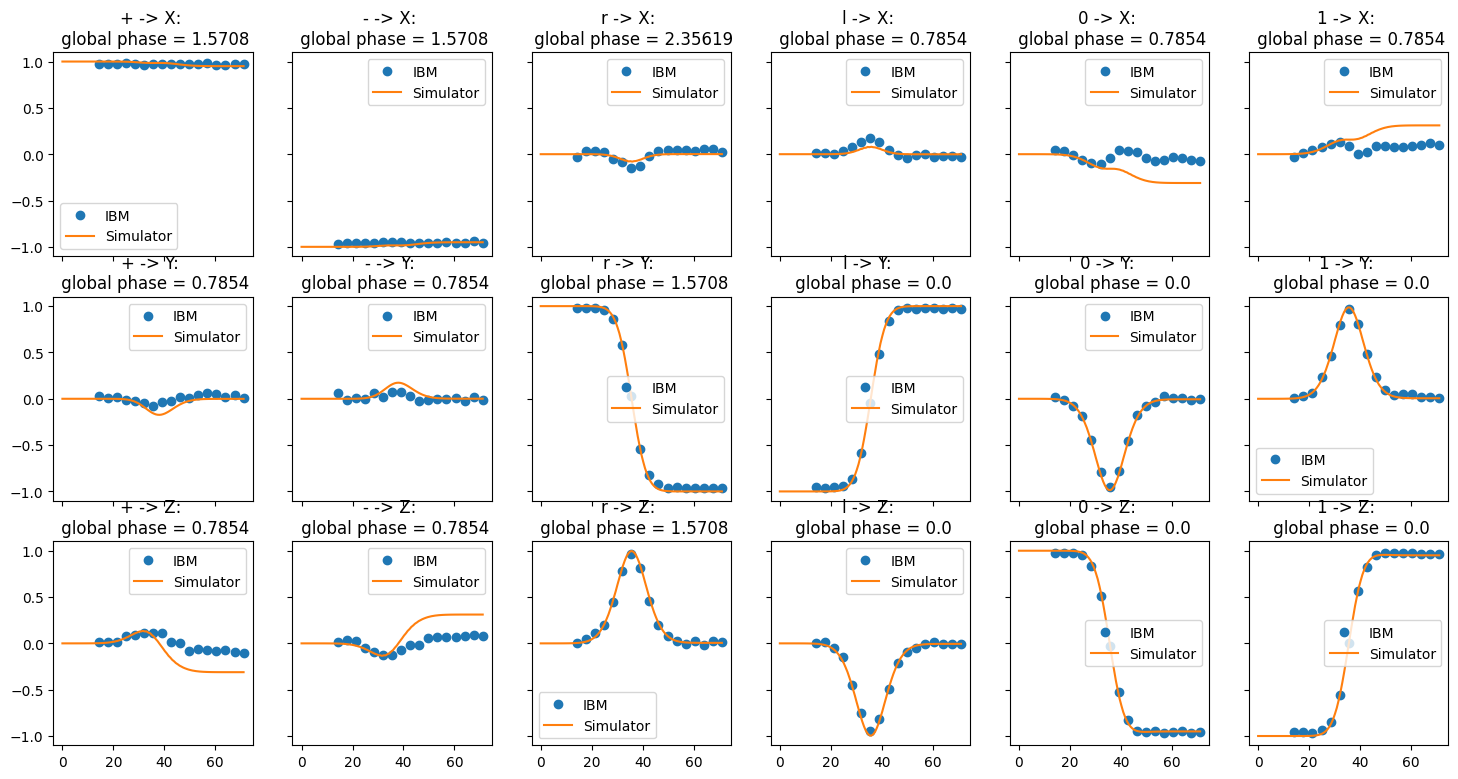

In [9]:
fig = plot_result(waveforms, results_df, exp_config, simulator)        

In [11]:
statuses = check_job_status(results_df, service)

Job crg8waswverg008vwvz0 status: JobStatus.DONE
Job crg8wb169sp0008qg3d0 status: JobStatus.DONE


In [19]:
from qiskit.providers import JobStatus

<JobStatus.DONE: 'job has successfully run'>

In [22]:
statuses[0] == JobStatus.DONE

True

In [25]:
JobStatus.DONE

<JobStatus.DONE: 'job has successfully run'>